In [1]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [2]:
def processing_data(data_path, height=224, width=224, batch_size=32,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader

In [3]:
from model import Backbone
class ArcfaceNet(nn.Module):
    def __init__(self, classes=10):
        super(ArcfaceNet, self).__init__()
        self.Arcnet = Backbone(num_layers=50,drop_ratio=0.6,mode='ir_se')
        self.Arcnet.load_state_dict(torch.load('model_ir_se50.pth'))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.Arcnet(x)
        out = self.fc(x)
        return out

In [4]:
torch.cuda.is_available()

True

In [5]:
data_path = './dataset'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=112, width=112, batch_size=42)

epochs = 60
model = ArcfaceNet(classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=5e-4)  # 优化器
print('加载完成...')

加载完成...


In [6]:
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max', 
                                                 factor=0.5,
                                                 patience=2)
# 损失函数
criterion = nn.CrossEntropyLoss()  

In [7]:
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()
    model.Arcnet.requires_grad = False
    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)


        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss
            
        loss_list.append(loss)
    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), './results/temp.pth')
print('Finish Training.')

39it [00:18,  2.09it/s]


step:1/60 || Total Loss: 1.9714


39it [00:17,  2.28it/s]


step:2/60 || Total Loss: 1.7510


39it [00:19,  2.03it/s]


step:3/60 || Total Loss: 1.8319


39it [00:24,  1.62it/s]


step:4/60 || Total Loss: 1.4966


39it [00:23,  1.63it/s]


step:5/60 || Total Loss: 1.4276


39it [00:24,  1.62it/s]


step:6/60 || Total Loss: 1.6420


39it [00:24,  1.61it/s]


step:7/60 || Total Loss: 1.2385


39it [00:23,  1.63it/s]


step:8/60 || Total Loss: 0.9974


39it [00:23,  1.64it/s]


step:9/60 || Total Loss: 0.9145


39it [00:23,  1.64it/s]


step:10/60 || Total Loss: 1.0689


39it [00:23,  1.65it/s]


step:11/60 || Total Loss: 0.7835


39it [00:24,  1.62it/s]


step:12/60 || Total Loss: 0.9989


39it [00:23,  1.64it/s]


step:13/60 || Total Loss: 0.7471


39it [00:24,  1.62it/s]


step:14/60 || Total Loss: 0.6911


39it [00:24,  1.61it/s]


step:15/60 || Total Loss: 0.5140


39it [00:23,  1.64it/s]


step:16/60 || Total Loss: 0.7588


39it [00:23,  1.67it/s]


step:17/60 || Total Loss: 0.7662


39it [00:23,  1.65it/s]


step:18/60 || Total Loss: 0.5776


39it [00:23,  1.66it/s]


step:19/60 || Total Loss: 0.4066


39it [00:23,  1.64it/s]


step:20/60 || Total Loss: 0.6283


39it [00:23,  1.67it/s]


step:21/60 || Total Loss: 0.5702


39it [00:23,  1.66it/s]


step:22/60 || Total Loss: 0.2420


39it [00:23,  1.66it/s]


step:23/60 || Total Loss: 0.7076


39it [00:23,  1.67it/s]


step:24/60 || Total Loss: 0.2551


39it [00:23,  1.66it/s]


step:25/60 || Total Loss: 0.2699


39it [00:23,  1.67it/s]


step:26/60 || Total Loss: 0.3937


39it [00:23,  1.65it/s]


step:27/60 || Total Loss: 0.5665


39it [00:23,  1.68it/s]


step:28/60 || Total Loss: 0.3930


39it [00:23,  1.66it/s]


step:29/60 || Total Loss: 0.2099


39it [00:23,  1.66it/s]


step:30/60 || Total Loss: 0.3851


39it [00:23,  1.66it/s]


step:31/60 || Total Loss: 0.2496


39it [00:23,  1.66it/s]


step:32/60 || Total Loss: 0.3729


39it [00:23,  1.67it/s]


step:33/60 || Total Loss: 0.4464


39it [00:23,  1.67it/s]


step:34/60 || Total Loss: 0.3036


39it [00:23,  1.66it/s]


step:35/60 || Total Loss: 0.3310


39it [00:23,  1.65it/s]


step:36/60 || Total Loss: 0.3180


39it [00:23,  1.66it/s]


step:37/60 || Total Loss: 0.2729


39it [00:23,  1.67it/s]


step:38/60 || Total Loss: 0.1633


39it [00:23,  1.65it/s]


step:39/60 || Total Loss: 0.0715


39it [00:23,  1.67it/s]


step:40/60 || Total Loss: 0.2136


39it [00:23,  1.68it/s]


step:41/60 || Total Loss: 0.0844


39it [00:23,  1.68it/s]


step:42/60 || Total Loss: 0.1179


39it [00:23,  1.67it/s]


step:43/60 || Total Loss: 0.2347


39it [00:23,  1.67it/s]


step:44/60 || Total Loss: 0.2893


39it [00:24,  1.62it/s]


step:45/60 || Total Loss: 0.2053


39it [00:23,  1.66it/s]


step:46/60 || Total Loss: 0.1628


39it [00:23,  1.68it/s]


step:47/60 || Total Loss: 0.2924


39it [00:23,  1.66it/s]


step:48/60 || Total Loss: 0.2747


39it [00:23,  1.65it/s]


step:49/60 || Total Loss: 0.2214


39it [00:23,  1.67it/s]


step:50/60 || Total Loss: 0.4520


39it [00:23,  1.65it/s]


step:51/60 || Total Loss: 0.2516


39it [00:23,  1.66it/s]


step:52/60 || Total Loss: 0.3014


39it [00:23,  1.64it/s]


step:53/60 || Total Loss: 0.1040


39it [00:23,  1.66it/s]


step:54/60 || Total Loss: 0.1180


39it [00:23,  1.64it/s]


step:55/60 || Total Loss: 0.1680


39it [00:24,  1.56it/s]


step:56/60 || Total Loss: 0.1588


39it [00:24,  1.57it/s]


step:57/60 || Total Loss: 0.1359


39it [00:24,  1.56it/s]


step:58/60 || Total Loss: 0.1841


39it [00:24,  1.57it/s]


step:59/60 || Total Loss: 0.1942


39it [00:24,  1.57it/s]


step:60/60 || Total Loss: 0.1979
Finish Training.


In [8]:
train_result = []
for loss in loss_list :
    train_result.append(loss.detach().to('cpu').numpy())

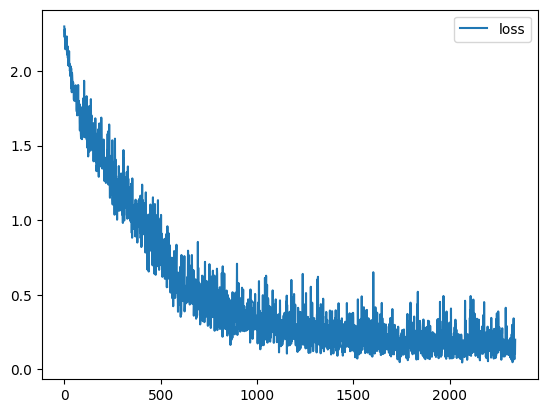

In [11]:
plt.plot(train_result,label = "loss")
plt.legend()
plt.show()

In [12]:
testpic = Image.open('t2.jpg')
labels = {0:'CL',1:'FBB',2:'HG',3:'HJ',4:'LHR',5:'LSS',6:'LYF',7:'PYY',8:'TY',9:'YM'}
testpic.show()
test_trans = T.Compose([
        T.Resize((112, 112)),
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])
testpic = test_trans(testpic)
testpic = testpic.view(1,testpic.shape[0],testpic.shape[1],testpic.shape[2])
model.eval()
with torch.no_grad():
    result = model(testpic.to(device))
    result = labels[np.argmax(result.to('cpu').numpy())]
print(result)

LHR


: 